In [1]:
## DriveEasy exploration notebook for off-line event extraction and lane assignment test. 
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import scipy.signal as signal
import datetime
from pathlib import Path

FIBER_DISTANCE = 2.5
SAMPLING_RATE = 200
THRESHOLD = 0.001 # picometer
BIN_SIZE = 40


class EventProperties:
    def __init__(self):
        self.timestamp = 0
        self.start = 0
        self.end = 1
        self.speed = 0
        self.ch = 1
        self.location = 1
        self.sensor = []
        self.axles = 0
        self.axle_lengths = []


class Event:
    def __init__(self):
        self.timestamp = datetime.datetime.now()
        self.event_id = 0
        self.fiber1_id = 0
        self.fiber2_id = 0
        self.fiber1_sensors = []
        self.fiber2_sensors = []
        self.info = ''
        self.wav1 = []
        self.wav2 = []

        
def normalize_tomax(wav):
    wav = (wav-np.min(wav))/(np.max(wav)-np.min(wav))
    return wav
    
# work with event2 with wls. Use min to aggregate data from difference sensors
def calculate_speed_qc_alg1(event2, lane_sensor):
    
    trace_temp1 = np.min(event2.wav1[:, lane_sensor], axis=1)
    trace_temp2 = np.min(event2.wav2[:, lane_sensor], axis=1)

    scaled_values_1 = normalize_tomax(trace_temp1)
    scaled_values_2 = normalize_tomax(trace_temp2)
    
    speed_valid = signal.correlate(scaled_values_1, scaled_values_2)
    
    if speed_valid.argmax() - len(event2.wav1)!= 0:
        speed_corr = -1 * FIBER_DISTANCE / (speed_valid.argmax() - len(event2.wav1)) * SAMPLING_RATE * 3.6
    else:
        speed_corr = 0
    return speed_corr

# work with event2 with wls. Use max of absolute value to aggregate data from difference sensors;
def calculate_speed_qc_alg2(event, lane_sensor):
    kk = np.min(event.wav1[:, lane_sensor], axis=0).argmin()
    # trace_temp1 = np.max(np.abs(event_list[j].wav1[:,lane_sensor_1]), axis=1)
    trace_temp1 = np.abs(event.wav1[:,kk])
    trace_temp2 = np.abs(event.wav2[:,kk])

    scaled_values_1 = normalize_tomax(trace_temp1)
    scaled_values_2 = normalize_tomax(trace_temp2)
#     trace_temp2 = np.max(np.abs(event.wav2[:, lane_sensor]), axis=1)
#     trace_temp1 = np.max(np.abs(event.wav1[:, lane_sensor]), axis=1)
    speed_valid = signal.correlate(scaled_values_1, scaled_values_2)
    if speed_valid.argmax() - len(event.wav1)!= 0:
        speed_corr = -1 * FIBER_DISTANCE / (speed_valid.argmax() - len(event.wav1)) * SAMPLING_RATE * 3.6
    else:
        speed_corr = 0

    peaks_temp2 = signal.find_peaks(scaled_values_2, prominence=0.0015)
    peaks_temp1 = signal.find_peaks(scaled_values_1, prominence=0.0015)
    if len(peaks_temp1[0]) == 0 or len(peaks_temp2[0]) == 0:
        return speed_corr, 0
    else:
        speed_agg_peak = -1*FIBER_DISTANCE / (peaks_temp1[0][0] - peaks_temp2[0][0]) * SAMPLING_RATE * 3.6
        return speed_corr, speed_agg_peak

# def define_baseline_alg2(data_seg, moving_ave, threshold):
#     return np.asarray(data_seg[:len(moving_ave)])-np.asarray(moving_ave) > threshold


def define_baseline_alg1(data_seg, threshold):
    if np.max(np.abs(data_seg - np.mean(data_seg))) > threshold:
        return 1
    else:
        return 0


# define the minimum distance in time between two vehicles: BIN_SIZE
def event_detection(data_trace, threshold=0.001, seg_length=BIN_SIZE):
    event_flag = []
    for i in range(int(len(data_trace)/seg_length)):
        event_flag.append(define_baseline_alg1(data_trace[i*seg_length:(i+1)*seg_length], threshold=threshold))
    return event_flag


def moving_average(data_set, periods=3):
    weights = np.ones(periods) / periods
    return np.convolve(data_set, weights, mode='valid')


def de_trend(data, n_ave=200):
    trend = moving_average(data, periods=n_ave)
    return data[:-(n_ave - 1)] - trend


def subtract_firstrow(df):
    first_row = df.iloc[[0]].values[0]
    df_temp = df.apply(lambda row: row - first_row, axis=1)
    return df_temp


def read_npz_file(filename):
    data = np.load(filename, allow_pickle=True)
    df = pd.DataFrame(data=data['wav'], index=data['timestamp'])

    df.columns = [f'sensor{i+1}' for i in range(25)]
    try:
        df['linenum'] = data['linenum']
    except:
        print('no linenum found')
    return df


def clean_wav(fiber):
    df_fiber = fiber
    check = df_fiber.index.to_series().diff().dt.total_seconds()
    df = pd.DataFrame(index=(df_fiber[check.values>0.006].index-datetime.timedelta(seconds=0.005)), columns=df_fiber[check.values>0.006].columns)
    df_fiber = df_fiber.append(df, ignore_index=False)
    df_fiber = df_fiber.sort_index()
    df_fiber.reset_index(inplace=True)
    df_fiber.columns = ['timestamp'] + [f'sensor{i+1}' for i in range(25)] + ['linenum']
#     df_fiber.columns = ['timestamp'] + [f'sensor{i+1}' for i in range(25)]
    return df_fiber


def find_outliers(df, total_sensorn=25, percent_low=0.001, percent_high=0.99999):

    y = df['sensor24']
    removed_outliers = y.between(y.quantile(0.5)-0.2, y.quantile(0.5)+0.2)

    for i in range(total_sensorn):
        y = df[f'sensor{i+1}']
        if np.max([y.max() - y.mean(), y.mean() - y.min()])> 0.5:
            removed_outliers = y.between(y.quantile(0.5)-0.5, y.quantile(0.5)+0.5) & removed_outliers
    index_names = df[~removed_outliers].index
    return index_names

def remove_outliers_from_paired_fibers(outlier_ch1, outlier_ch2, df_1, df_2):
    total_outliers = list(dict.fromkeys(outlier_ch1.to_list() + outlier_ch2.to_list()))
    df_1.loc[total_outliers, [f'sensor{i + 1}' for i in range(25)]] = np.nan
    df_2.loc[total_outliers, [f'sensor{i + 1}' for i in range(25)]] = np.nan

    # fix missing data in the middle using interpolate
    df_1.interpolate(inplace=True)
    df_2.interpolate(inplace=True)

    # fix missing data in the head
    df_1 = df_1.fillna(method='bfill')
    df_2 = df_2.fillna(method='bfill')
    return df_1, df_2


In [2]:
data_path = Path(r'C:\Users\qchen\PARC\Fibridge-PARC - Drive Easy\AustraliaDeploy\Francis\raw_data\Melbourne_time_20201201\wav')
filename_1 = data_path / r'wav_20201130_223319_F01_UTC.npz'
filename_2 = data_path / r'wav_20201130_223319_F02_UTC.npz'
filename_3 = data_path / r'wav_20201130_223319_F03_UTC.npz'
filename_4 = data_path / r'wav_20201130_223319_F04_UTC.npz'

In [3]:
### npz
df_1 = read_npz_file(filename_1)
df_2 = read_npz_file(filename_2)
df_3 = read_npz_file(filename_3)
df_4 = read_npz_file(filename_4)

In [4]:
print(len(df_1))
print(len(df_2))
print(len(df_3))
print(len(df_4))

729993
729993
729993
729993


In [5]:
df_1 = clean_wav(df_1)
df_2 = clean_wav(df_2)
df_3 = clean_wav(df_3)
df_4 = clean_wav(df_4)

In [6]:
outliers_1 = find_outliers(df_1, total_sensorn=25, percent_low=0.000005, percent_high=0.99995)
outliers_2 = find_outliers(df_2, total_sensorn=25, percent_low=0.000005, percent_high=0.99995)
outliers_3 = find_outliers(df_3, total_sensorn=24, percent_low=0.000005, percent_high=0.99995)
outliers_4 = find_outliers(df_4, total_sensorn=25, percent_low=0.000005, percent_high=0.99995)

In [7]:
print(len(outliers_1))
print(len(outliers_2))
print(len(outliers_3))
print(len(outliers_4))

131
52
12
23


In [8]:
trim_outliers = False
if trim_outliers:
    dff_1, dff_2 = remove_outliers_from_paired_fibers(outliers_1, outliers_2, df_1, df_2)
    dff_3, dff_4 = remove_outliers_from_paired_fibers(outliers_3, outliers_4, df_3, df_4)
else:
    dff_1 = df_1
    dff_2 = df_2
    dff_3 = df_3
    dff_4 = df_4

In [10]:
dff_2.head(5)
# df_2.tail(1)

,timestamp,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9,...,sensor17,sensor18,sensor19,sensor20,sensor21,sensor22,sensor23,sensor24,sensor25,linenum
0,2020-11-30 22:33:19.000000,1511.7025,1515.2310,1518.8580,1522.1971,1525.4821,1528.8353,1532.0165,1535.0848,1539.7865,...,1563.927,1567.1589,1570.3666,1573.7748,1576.7589,1579.7448,1582.6381,1585.1345,1588.1520,2033
1,2020-11-30 22:33:19.005004,1511.7024,1515.2310,1518.8582,1522.1973,1525.4822,1528.8353,1532.0164,1535.0848,1539.7866,...,1563.927,1567.1588,1570.3667,1573.7749,1576.7589,1579.7446,1582.6382,1585.1346,1588.1521,2034
2,2020-11-30 22:33:19.010008,1511.7025,1515.2308,1518.8582,1522.1976,1525.4823,1528.8352,1532.0166,1535.0845,1539.7867,...,1563.927,1567.1589,1570.3667,1573.7749,1576.7589,1579.7446,1582.6383,1585.1346,1588.1522,2035
3,2020-11-30 22:33:19.015012,1511.7025,1515.2310,1518.8580,1522.1976,1525.4823,1528.8353,1532.0164,1535.0848,1539.7866,...,1563.927,1567.1591,1570.3668,1573.7749,1576.7590,1579.7446,1582.6383,1585.1346,1588.1521,2036
4,2020-11-30 22:33:19.020017,1511.7024,1515.2308,1518.8582,1522.1978,1525.4824,1528.8353,1532.0166,1535.0847,1539.7865,...,1563.927,1567.1589,1570.3667,1573.7749,1576.7590,1579.7445,1582.6383,1585.1345,1588.1520,2037


In [ ]:
dff_4.plot(y=['sensor25'])

In [ ]:
# trim error lines in the head if there is any
# dff_1 = dff_1.iloc[1:,:]
# dff_1.reset_index(drop=True,inplace=True)
# dff_2 = dff_2.iloc[1:,:]
# dff_2.reset_index(drop=True, inplace=True)

In [ ]:
# exam the loaded data
# set index of sensor to look at
import matplotlib.dates as mdates
k = 9
fig = plt.figure()
plt.clf()
ax = fig.add_subplot(111)

# # if there is a built-in timestamp
ax.plot(np.asarray(dff_1.iloc[:, 0]), np.asarray(dff_1.iloc[:, k+1])-dff_1.iloc[0,k+1], label='ch_1')
# ax.plot(df_2.iloc[:, 0], np.asarray(df_2.iloc[:, k])-df_2.iloc[0,k], label='ch_2')

# ax.set_ylim([-0.05, 0.05])

# ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %H-%M-%s-%f'))
# fig.autofmt_xdate()

# ax.plot(np.asarray(dff_1.iloc[:, 4]), 'r', label='ch_1')
# ax.plot(np.asarray(dff_2.iloc[:, 23]), 'b', label='ch_2')
# ax.plot(np.asarray(dff_2.iloc[:, 8]), 'g', label='ch_2')
# ax.plot(np.asarray(df_2.iloc[:40000, k+1]), 'g', label='ch_2')

In [17]:
# Francis ch1, ch2: lane3_3_15; lane4_16_25; lane2_11-22; lane1_1_10
# M80 ch3, ch4: lane5_1_11; lane4_12_21; lane3_; lane2_
street_id = 'Francis'
lane_id = 3

sensor_arrangement = {'Francis':[[], list(range(1, 11)), list(range(11, 23)), list(range(3,16)), list(range(16, 26))], 
                      'M80':[[], [], list(range(16, 26)), list(range(6, 16)), list(range(12, 22)), list(range(1, 12))]}

lane_sensor = sensor_arrangement[street_id][lane_id]

In [18]:
lane_sensor

[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [19]:
# Identify the triggering fiber. lane1,2, df_3, df_4; lane 3, 4, df_1,2
trace_leading = np.asarray(dff_1.loc[:,[f'sensor{i}' for i in lane_sensor]])
trace_trailing = np.asarray(dff_2.loc[:,[f'sensor{i}' for i in lane_sensor]])

In [20]:
BIN_SIZE=40
for i in range(len(trace_leading[0])):
    trace_leading[:len(trace_leading)-BIN_SIZE+1,i]=de_trend(trace_leading[:,i], n_ave=BIN_SIZE)
    trace_trailing[:len(trace_trailing)-BIN_SIZE+1,i]=de_trend(trace_trailing[:,i], n_ave=BIN_SIZE)

trace_leading = np.max(np.abs(trace_leading[:len(trace_leading)-BIN_SIZE+1, :]), axis=1)
trace_trailing = np.max(np.abs(trace_trailing[:len(trace_trailing)-BIN_SIZE+1, :]), axis=1)

event_vis_leading = event_detection(trace_leading, threshold=0.001, seg_length=BIN_SIZE)
event_vis_trailing = event_detection(trace_trailing, threshold=0.001, seg_length=BIN_SIZE)


<IPython.core.display.Javascript object>


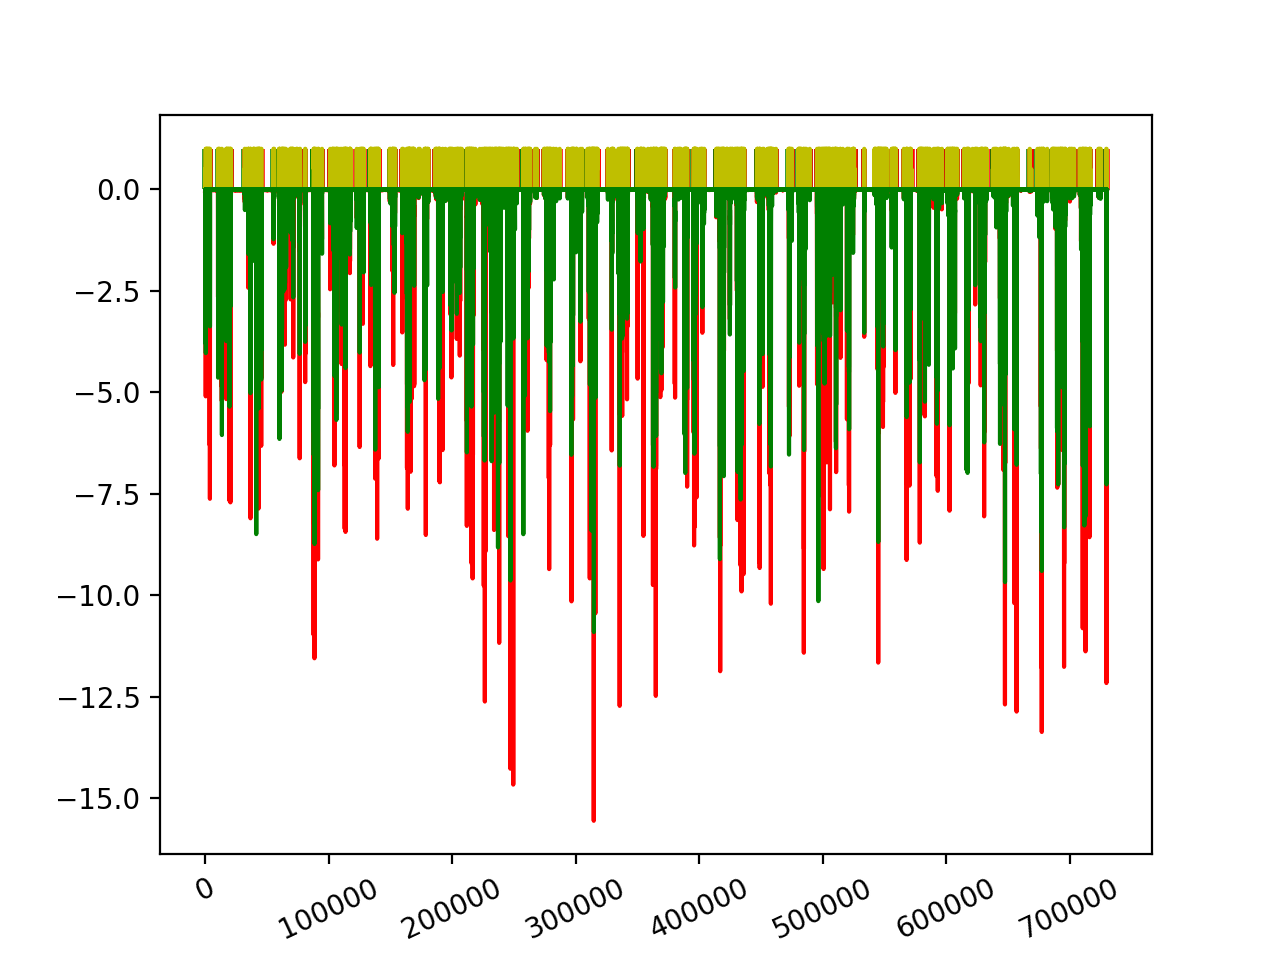

Total peak detected: 661
Total peak detected: 654
Total peak detected: 687


In [21]:
timeseg = np.linspace(0, len(event_vis_leading)*BIN_SIZE, len(event_vis_leading))
plt.figure()
plt.clf()
# plot_time = [dff_1['timestamp'][0] + datetime.timedelta(hours=11, seconds=j*1/SAMPLING_RATE) for j in timeseg]
# plot_trace_time = dff_1['timestamp'] + datetime.timedelta(hours=11)
# plt.plot(plot_time, event_vis, 'r')
# plt.plot(plot_trace_time[:len(trace_t)-BIN_SIZE], trace_t[:-BIN_SIZE]*-100, 'b')

event_vis_combined = np.asarray(event_vis_leading)*0.5+np.asarray(event_vis_trailing)*0.5

# plt.plot(timeseg, event_vis_leading, 'r')
# plt.plot(timeseg, event_vis_trailing, 'g')
plt.plot(timeseg, event_vis_combined, 'y')
plt.plot(trace_leading*-20,'r')
plt.plot(trace_trailing*-20,'g')
# plt.ylim([-1,1.5])
plt.xticks(rotation=25)
peaks_leading = signal.find_peaks(event_vis_leading, width=1,distance=2)
peaks_trailing = signal.find_peaks(event_vis_trailing, width=1,distance=2)
peaks_combined = signal.find_peaks(event_vis_combined, width=1,distance=2)
# plt.plot(timeseg[peaks[0]], peaks[1]['width_heights'],'*b')
for j in range(len(peaks_combined[0])):
    plt.vlines(x=peaks_combined[1]['left_bases'][j]*BIN_SIZE, ymin=0, ymax=1,colors='green', lw=2)
    plt.vlines(x=peaks_combined[1]['right_bases'][j]*BIN_SIZE, ymin=0, ymax=1,colors='red',lw=2)
print('Total peak detected: {}'.format(len(peaks_leading[0])))
print('Total peak detected: {}'.format(len(peaks_trailing[0])))
print('Total peak detected: {}'.format(len(peaks_combined[0])))

In [22]:
def event_corp(df_1, df_2, event_properties, ap_bin, total_sensorn=25, fiber1_id=1, fiber2_id=2):
    event_temp = Event()
    event_temp.timestamp = event_properties.timestamp
    event_temp.event_id = len(event_list)
    event_temp.fiber1_id = fiber1_id
    event_temp.fiber2_id = fiber2_id
    event_temp.fiber1_sensors = list(range(1, total_sensorn+1))
    event_temp.fiber2_sensors = list(range(1, total_sensorn+1))
    event_temp.wav1 = df_1.iloc[event_properties.start:event_properties.end+BIN_SIZE*ap_bin, 1:total_sensorn+1]
    event_temp.wav1 = event_temp.wav1.reset_index(drop=True)
    event_temp.wav1 = np.asarray(subtract_firstrow(event_temp.wav1))
    
#     dp_shift = df_1.iloc[event_properties.start, 26]- df_2.iloc[event_properties.start, 26]
    dp_shift = 0
    
    event_temp.wav2 = df_2.iloc[event_properties.start+dp_shift:event_properties.end +dp_shift+ BIN_SIZE * ap_bin, 1:total_sensorn+1]
    event_temp.wav2 = event_temp.wav2.reset_index(drop=True)
    event_temp.wav2 = np.asarray(subtract_firstrow(event_temp.wav2))
    return event_temp

In [23]:
dff_1 = dff_1
dff_2 = dff_2

In [24]:
lane_sensor_1 = np.asarray(lane_sensor)-1

In [25]:
lane_sensor_1

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [26]:
event_prop_list = []
event_list = []
ap_bin = 1
speed_temp = []

for i in range(len(peaks_combined[0])):
    event_prop_temp = EventProperties()
    event_prop_temp.start = int(peaks_combined[1]['left_bases'][i]*BIN_SIZE)
    event_prop_temp.end = int(peaks_combined[1]['right_bases'][i]*BIN_SIZE)
    if len(event_prop_list)>0:
        if event_prop_temp.start < event_prop_list[-1].end+0.25*BIN_SIZE:
            print('overlength event #{}'.format(i))
            event_prop_list[-1].end = event_prop_temp.end
            event_prop_temp = event_prop_list[-1]
            event_list[-1] = event_corp(dff_1, dff_2, event_prop_temp, ap_bin, total_sensorn=25)
            event_temp = event_list[-1]
            continue
    event_prop_temp.timestamp = dff_1.iloc[event_prop_temp.start, 0]
    event_temp = event_corp(dff_1,dff_2, event_prop_temp, ap_bin, total_sensorn=25)
    
    
#     
# #         axle_trace = np.abs(np.min(event_temp.wav1, axis=0))
# #         axle_peaks = signal.find_peaks(axle_trace, prominence=0.002)
# #         print(axle_peaks[0])
# #         ui = input('Continue? Y/N: (Y)')
# #         if ui == 'N':
# #             break
#         continue
    
    event_list.append(event_temp)
    event_prop_list.append(event_prop_temp)

print('Total event detected: {}'.format(len(event_list)))

overlength event #15
overlength event #23
overlength event #26
overlength event #29
overlength event #36
overlength event #38
overlength event #40
overlength event #45
overlength event #48
overlength event #49
overlength event #52
overlength event #53
overlength event #60
overlength event #74
overlength event #75
overlength event #81
overlength event #91
overlength event #92
overlength event #97
overlength event #101
overlength event #102
overlength event #107
overlength event #108
overlength event #119
overlength event #124
overlength event #125
overlength event #131
overlength event #135
overlength event #145
overlength event #146
overlength event #148
overlength event #152
overlength event #153
overlength event #160
overlength event #161
overlength event #173
overlength event #189
overlength event #195
overlength event #200
overlength event #215
overlength event #224
overlength event #243
overlength event #248
overlength event #264
overlength event #268
overlength event #270
overlen

In [27]:
np.savez_compressed('Francis_1201_0930_lane_3_trial_1217_raw_triggered_events.npz', events=event_list)

<IPython.core.display.Javascript object>


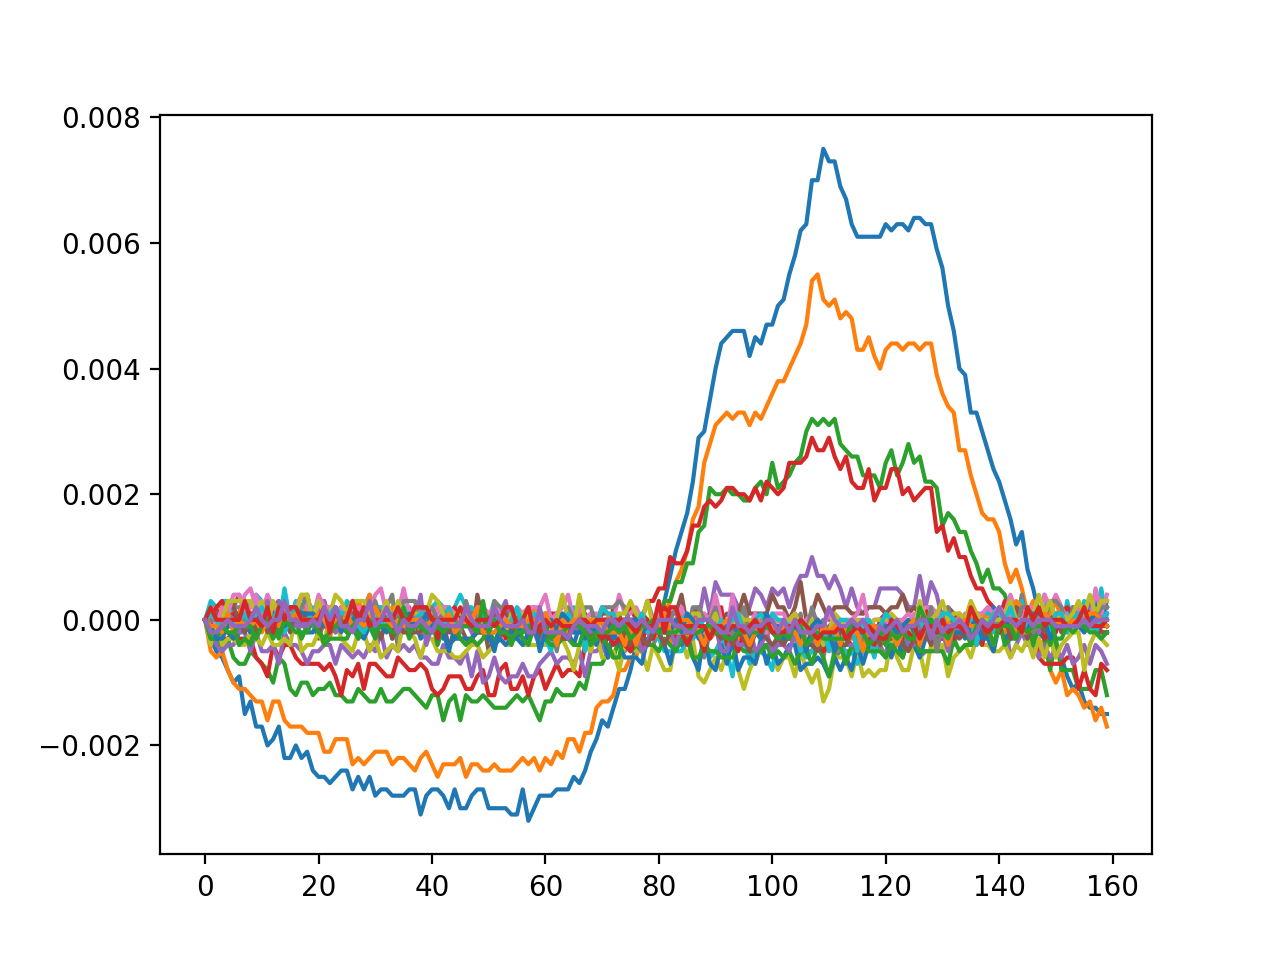

<IPython.core.display.Javascript object>


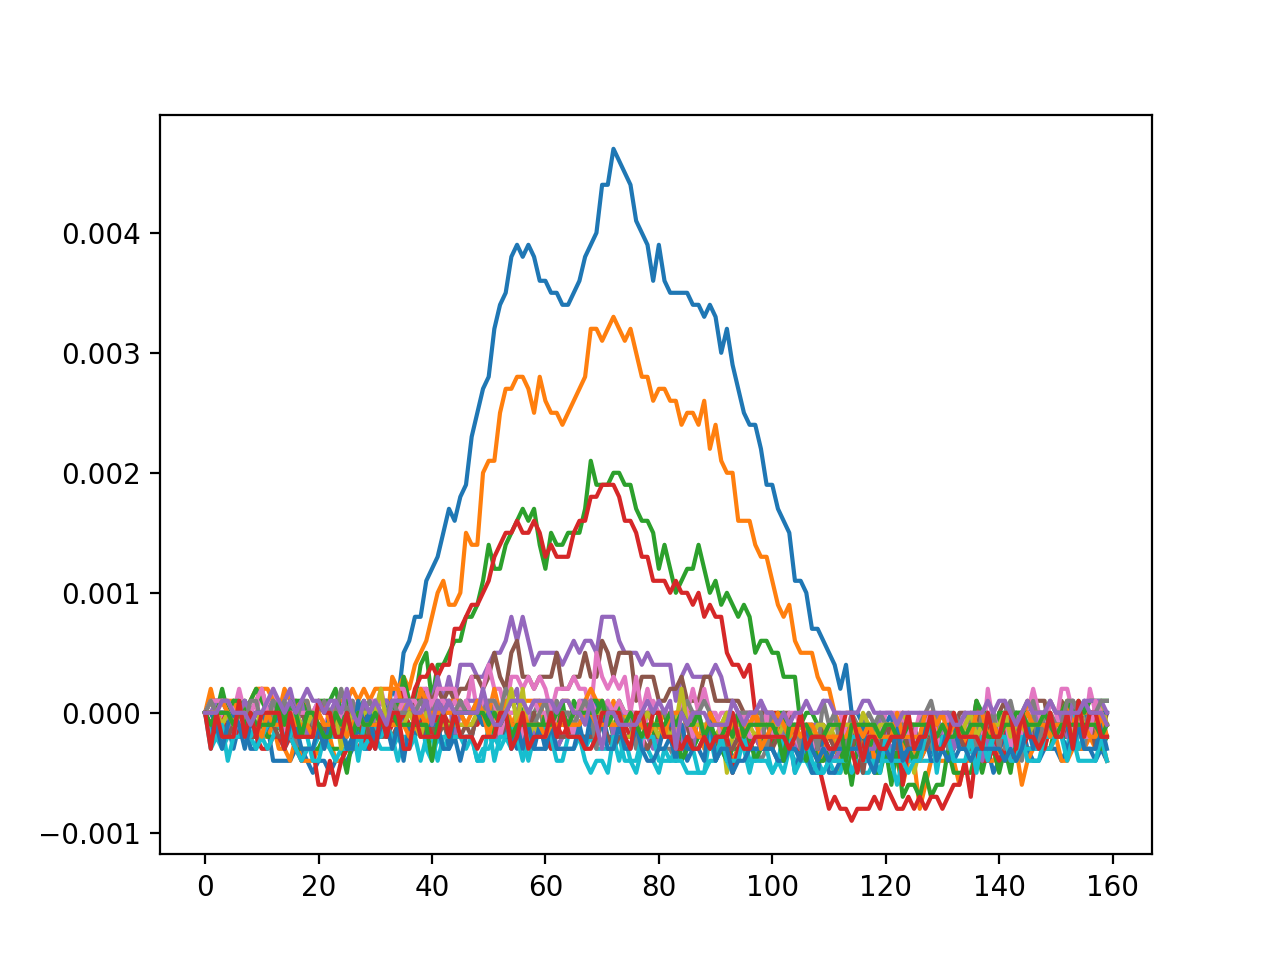

<IPython.core.display.Javascript object>


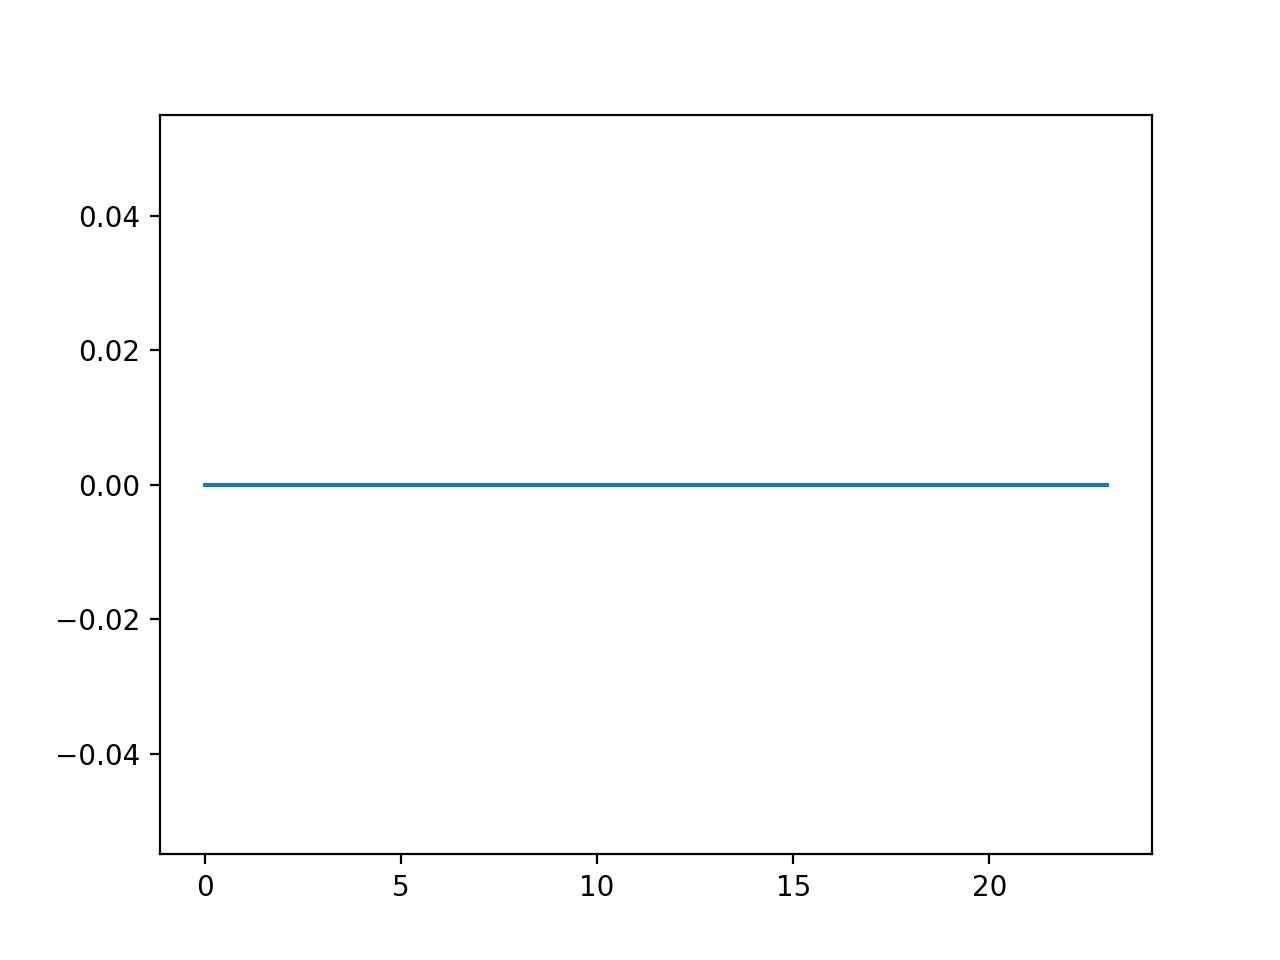

[ 2  3  4  5  6  7  8  9 10 11 12 13 14]


In [43]:
i=422
plt.figure()
plt.clf()
plt.plot(event_list[i].wav1[:,:25])

plt.figure()
plt.clf()
plt.plot(event_list[i].wav2[:,:25])

# lane assignment test region
lane_trace = pd.DataFrame()
for j in range(24):
    lane_trace['sensor{}'.format(j+1)]=event_detection(event_list[i].wav1[:,j], threshold=0.002, seg_length=3)

plt.figure()
lane_combined = np.sum(lane_trace, axis=0)
peaks_lane = signal.find_peaks(lane_combined, prominence=1, distance=3)
# print(int(np.average(peaks_lane[0])) in lane_sensor_1)
print(lane_sensor_1)
plt.plot(np.asarray(lane_combined))
plt.plot(peaks_lane[0], [1,]*len(peaks_lane[0]), '*b')
    

In [30]:
def normalize_tomax(wav):
    wav = wav/np.max(wav)
    return wav


def identify_lane(event, _lane_sensor_1):

#     start = np.max([wave_center-BIN_SIZE, 0])
#     end = np.min([wave_center+BIN_SIZE, len(wav)])
#     _axle_trace_1 = np.std(np.abs(event.wav1), axis=0)
    _axle_trace_1 = np.max(np.abs(event.wav1), axis=0)
    _axle_peaks_1 = signal.find_peaks(_axle_trace_1, prominence=0.01, distance=2)
    
    _axle_trace_2 = np.max(np.abs(event.wav2), axis=0)
    _axle_peaks_2 = signal.find_peaks(_axle_trace_2, prominence=0.01, distance=2)
    
    if len(_axle_peaks_1[0]) > len(_axle_peaks_2[0]):
        axle_peaks = _axle_peaks_1
    else:
        axle_peaks = _axle_peaks_2
    
    if len(axle_peaks[0]) == 0:
        print('No wheel found!')
        return 0
    _cog = np.average(axle_peaks[0])
# Francis street, Westbound
    if len(axle_peaks[0]) <= 2:
        if axle_peaks[0][-1] in _lane_sensor_1:
            return 1
        else:
            return 0
            # specific to Francis street lane_3
#             if int(_cog) < _lane_sensor_1[-1] + 0:
#                 print('cross lane')
#                 return 1
#             else:
#                 return 0
        
    else:
        if ((axle_peaks[0]>=_lane_sensor_1[0]) & (axle_peaks[0]<=_lane_sensor_1[-1])).sum()>=2:
            return 1
        else:
            return 0
        
        
def identify_lane2(event, _lane_sensor, threshold=0.0015, total_sensorn=25, left_wheel_index=0):
    # left_wheel_index: 0: left is closer to smaller index sensors; -1: left is closer to larger index sensors
    lane_trace = pd.DataFrame()
    for j in range(total_sensorn):
        lane_trace['sensor{}'.format(j+1)]=event_detection(event.wav1[:,j], threshold=threshold, seg_length=3)
    peaks_lane = signal.find_peaks(np.sum(lane_trace, axis=0), prominence=1, distance=3)
    _cog = np.average(peaks_lane[0])
    if len(peaks_lane[0]) == 0:
        print('No wheel found!')
        return 0
    if len(peaks_lane[0]) <= 2:
#         if peaks_lane[0][left_wheel_index] in _lane_sensor: 
        if int(_cog) in _lane_sensor:
            return 1
        else:
            return 0
    else:
        if ((peaks_lane[0]>=_lane_sensor[0]) & (peaks_lane[0]<=_lane_sensor[-1])).sum()>=2:
            return 1
        else:
            return 0

In [31]:
lane_sensor_1 = np.asarray(lane_sensor)-1
print(lane_sensor_1)
is_inlane = []
for i in range(len(event_list)):
    if identify_lane2(event_list[i], lane_sensor_1, total_sensorn=25, threshold=0.001, left_wheel_index=-1) == 1:
        print('Vehicle on the lane event!#{}'.format(i))
        is_inlane.append(i)

[ 2  3  4  5  6  7  8  9 10 11 12 13 14]
Vehicle on the lane event!#0
Vehicle on the lane event!#1
Vehicle on the lane event!#2
Vehicle on the lane event!#3
Vehicle on the lane event!#4
Vehicle on the lane event!#5
Vehicle on the lane event!#6
Vehicle on the lane event!#7
Vehicle on the lane event!#8
Vehicle on the lane event!#9
Vehicle on the lane event!#10
Vehicle on the lane event!#11
Vehicle on the lane event!#12
Vehicle on the lane event!#13
Vehicle on the lane event!#14
Vehicle on the lane event!#15
Vehicle on the lane event!#16
Vehicle on the lane event!#17
Vehicle on the lane event!#18
Vehicle on the lane event!#19
Vehicle on the lane event!#20
Vehicle on the lane event!#21
Vehicle on the lane event!#22
Vehicle on the lane event!#23
Vehicle on the lane event!#24
Vehicle on the lane event!#25
Vehicle on the lane event!#26
Vehicle on the lane event!#27
Vehicle on the lane event!#28
Vehicle on the lane event!#29
Vehicle on the lane event!#30
Vehicle on the lane event!#31
Vehicle o

c:\driveeasy2020\daq\driveeasy\venv-driveeasy\lib\site-packages\numpy-1.19.4-py3.8-win-amd64.egg\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\driveeasy2020\daq\driveeasy\venv-driveeasy\lib\site-packages\numpy-1.19.4-py3.8-win-amd64.egg\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


No wheel found!
No wheel found!
No wheel found!
No wheel found!
Vehicle on the lane event!#49
Vehicle on the lane event!#50
Vehicle on the lane event!#51
Vehicle on the lane event!#52
Vehicle on the lane event!#53
Vehicle on the lane event!#54
Vehicle on the lane event!#55
Vehicle on the lane event!#56
No wheel found!
Vehicle on the lane event!#58
Vehicle on the lane event!#59
Vehicle on the lane event!#60
Vehicle on the lane event!#61
Vehicle on the lane event!#62
Vehicle on the lane event!#63
Vehicle on the lane event!#64
No wheel found!
Vehicle on the lane event!#66
Vehicle on the lane event!#67
Vehicle on the lane event!#68
Vehicle on the lane event!#69
Vehicle on the lane event!#70
Vehicle on the lane event!#71
Vehicle on the lane event!#72
Vehicle on the lane event!#73
Vehicle on the lane event!#74
Vehicle on the lane event!#75
Vehicle on the lane event!#76
Vehicle on the lane event!#77
No wheel found!
Vehicle on the lane event!#79
Vehicle on the lane event!#80
Vehicle on the lan

Vehicle on the lane event!#318
Vehicle on the lane event!#319
Vehicle on the lane event!#320
Vehicle on the lane event!#321
Vehicle on the lane event!#322
Vehicle on the lane event!#323
Vehicle on the lane event!#324
Vehicle on the lane event!#325
Vehicle on the lane event!#326
Vehicle on the lane event!#327
Vehicle on the lane event!#328
Vehicle on the lane event!#329
Vehicle on the lane event!#330
Vehicle on the lane event!#331
Vehicle on the lane event!#332
Vehicle on the lane event!#333
Vehicle on the lane event!#334
Vehicle on the lane event!#335
Vehicle on the lane event!#336
Vehicle on the lane event!#337
Vehicle on the lane event!#338
No wheel found!
Vehicle on the lane event!#340
Vehicle on the lane event!#341
Vehicle on the lane event!#342
Vehicle on the lane event!#343
Vehicle on the lane event!#344
Vehicle on the lane event!#345
Vehicle on the lane event!#346
Vehicle on the lane event!#347
Vehicle on the lane event!#348
Vehicle on the lane event!#349
Vehicle on the lane eve

In [32]:
detected_events = []
detected_event_property = []
for i in is_inlane:
    event_prop_temp = EventProperties()
    event_prop_temp.timestamp=event_list[i].timestamp
    detected_events.append(event_list[i])
    detected_event_property.append(event_prop_temp)
print('Total on the lane:{}'.format(len(detected_events)))

Total on the lane:550


In [33]:
np.savez_compressed('Francis_1201_0930_lane_3_trial_1217_filtered_triggered_events.npz', events=detected_events)

<IPython.core.display.Javascript object>


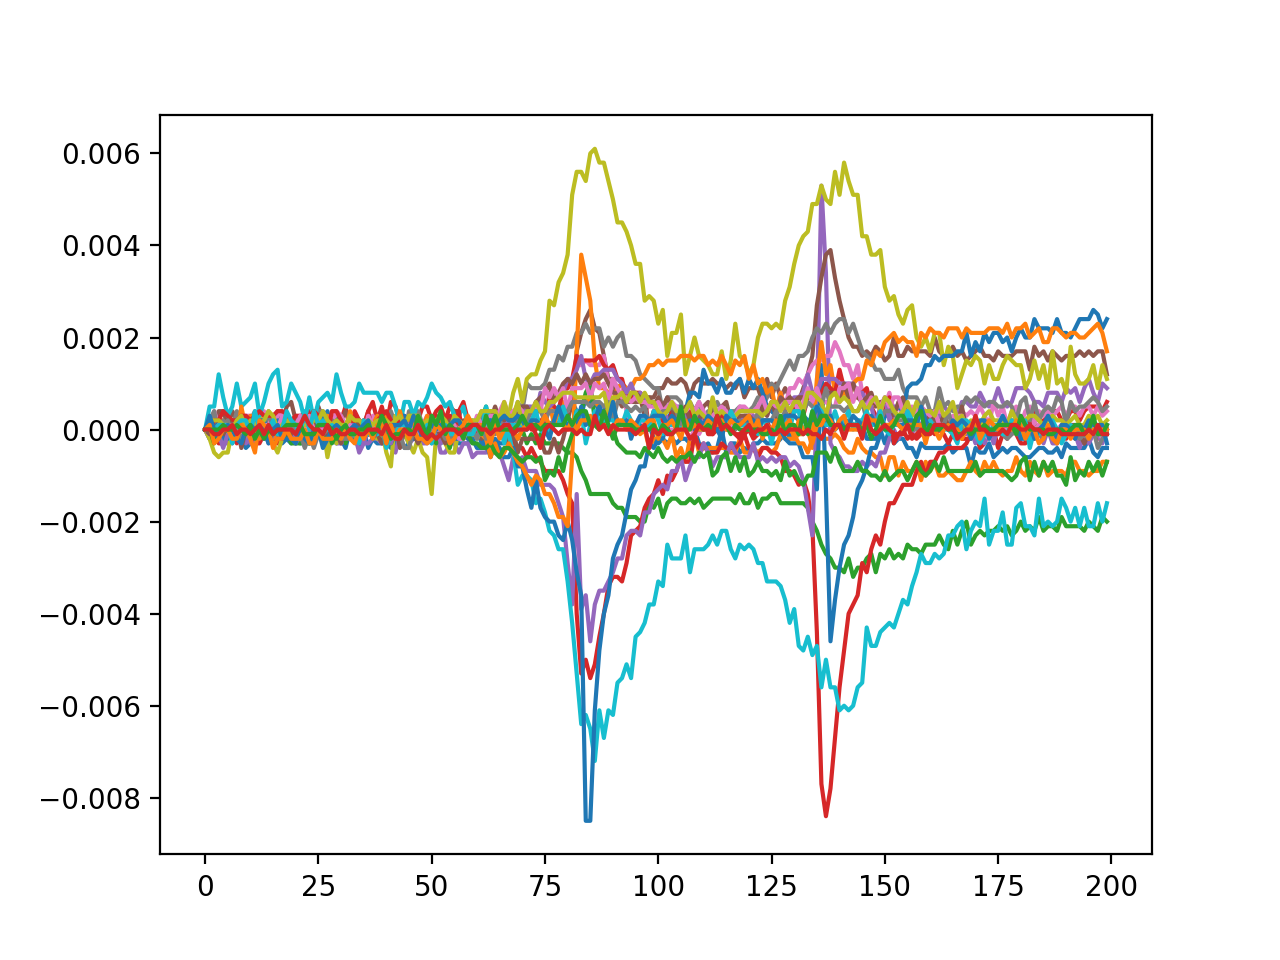

<IPython.core.display.Javascript object>


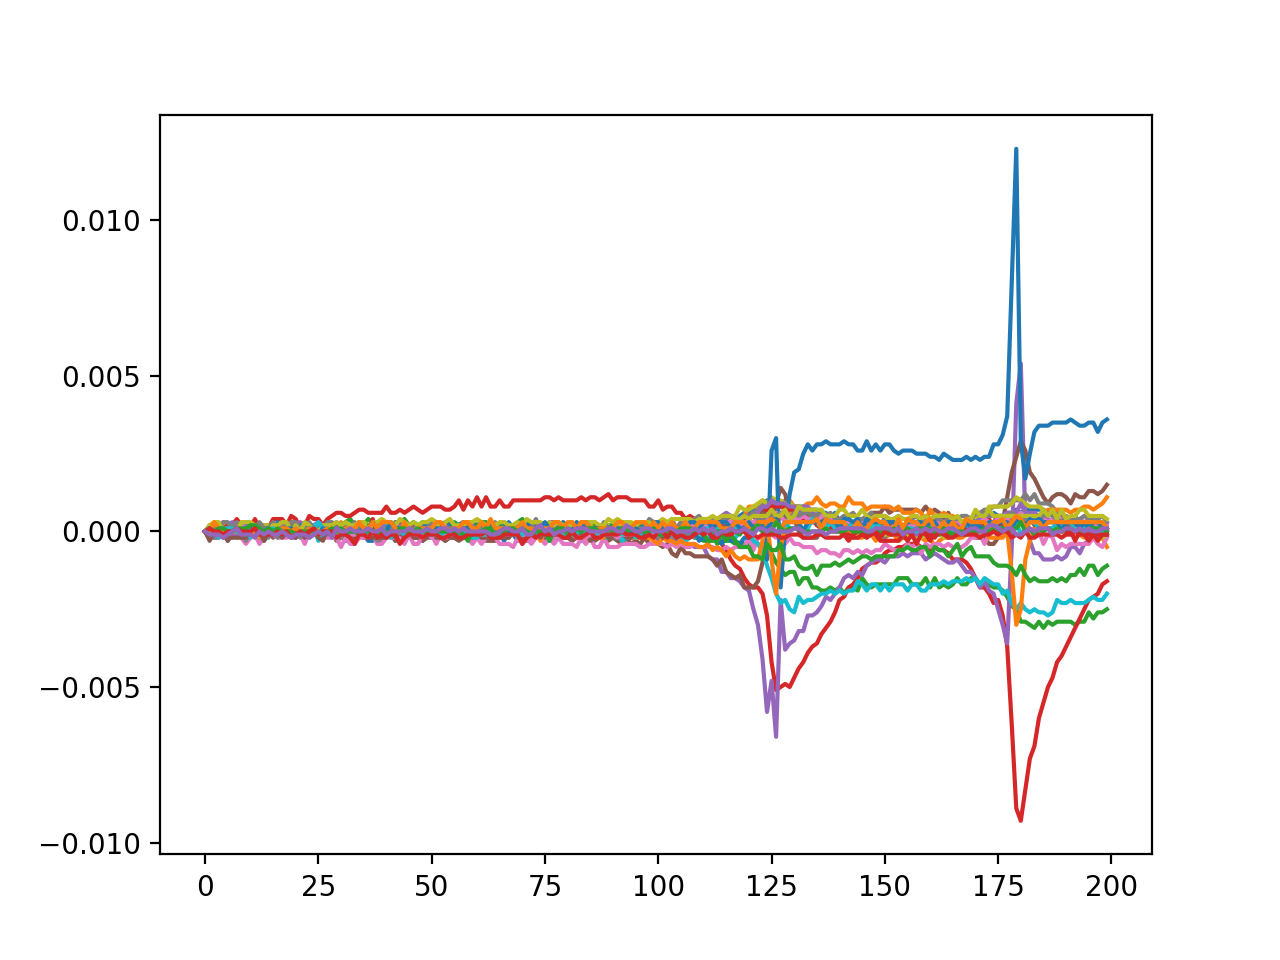

In [36]:
i=24
plt.figure()
plt.clf()
plt.plot(event_list[i].wav1[:,:24])

plt.figure()
plt.clf()
plt.plot(event_list[i].wav2[:,:25])

In [37]:
# lane assignment test region
i = 556
lane_trace = pd.DataFrame()
for j in range(24):
    lane_trace['sensor{}'.format(j+1)]=event_detection(detected_events[i].wav1[:,j], threshold=0.002, seg_length=3)

IndexError: list index out of range

In [ ]:
plt.figure()
peaks_lane = signal.find_peaks(np.sum(lane_trace, axis=0), prominence=1, distance=3)
plt.plot(np.sum(lane_trace, axis=0))
plt.plot(peaks_lane[0], [1,]*len(peaks_lane[0]), '*b')


In [ ]:
# axle_trace = np.std(np.abs(event_list[i].wav1), axis=0)
axle_trace = np.max(np.abs(detected_events[i].wav2), axis=0)
axle_peaks = signal.find_peaks(axle_trace, prominence=0.01, distance=2)
print(len(axle_peaks[0]))
print(axle_peaks[0])
print(lane_sensor_1)
print(((axle_peaks[0]>=lane_sensor_1[0]) & (axle_peaks[0]<=lane_sensor_1[-1])).sum())

In [ ]:
plt.figure()
plt.clf()
plt.plot(axle_trace)
plt.plot(axle_peaks[0], [0]*len(axle_peaks[0]), '*b')

# plt.plot(event_temp.wav1[:, 8])
print(np.average(axle_peaks[0]))
print(i)
plt.title('#{}. Timestamp: {}'.format(i, event_prop_list[i].timestamp+datetime.timedelta(hours=11)))